In [1]:
# from __future__ import division, print_function, absolute_import
%matplotlib inline
import numpy as np

from phidl import Device, Layer, LayerSet, make_device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu

# import customed geolib
import mine as mn
import matplotlib.pyplot as plt

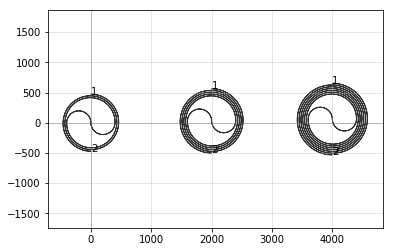

DeviceReference (parent Device "archimedes000021", ports [1, 2], origin (0, 0), rotation 0, x_reflection False)

In [7]:
D = Device('s')
w = 1.5
pd = 2e3

tl = 10e3
shift = 30
SP=[D << mn.archimedes(distance=30,width=w, n=i+1, bent=200, angle_resolution=0.5).move((pd*i,i*shift)) for i in range(3)]

qp(D)
pg.outline(D,distance=8).write_gds('view.gds')

SP[0]

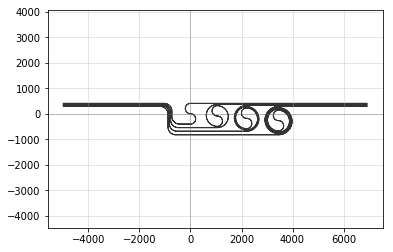

In [81]:
D = Device('SEMI')
D_b = Device('lb')
width = 1.5
xs = 50
ys = 90
for i in range(4):
    CEL = Device('CEL')
    foo = 1e3+i*xs
    SS = CEL << semi_spiral(bend=430,shift=xs,width=width,layer=1, n=i).move((foo*i,-ys*i))
    EXR = CEL << mn.extend(port=SS.ports[2],length=6.5e3-(foo+xs)*i)
    EXL = CEL << mn.extend(port=SS.ports[1],length=(foo)*i)
    CN = pg.connector((-5e3,SS.ports[2].midpoint[1]),width,orientation=0)
    CEL << pr.route_manhattan(CN.ports[1],EXL.ports[2],bendType='circular',radius=300)    
    L = CEL.area()/width
    D_b << pg.text(text='WL%.2f'% L, position=((foo*i,100-ys*i)))
    D << CEL
#       D.area()/width

D_out = pg.outline(D,distance=10)
D_out << D_b

D_out.flatten().write_gds('190415_spiral_align.gds')
qp(D)

In [55]:
SS.ports[2].midpoint[1]

405.0

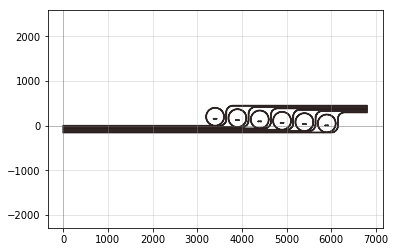

In [83]:
D = Device('CJC')

def z_shape(width=1.5, radius=50, mid=50, left=100, right=100, layer=0):
    D = Device('z_shape')
    LW = D << mn.waveguide(width=width,length=left,layer=layer)
    BD1 = D << pg.turn(port=LW.ports[2],angle=90,radius=radius,angle_resolution=0.5)
    MD = D << mn.extend(port=BD1.ports[2],length=mid)
    BD2 = D << pg.turn(port=MD.ports[2],angle=-90,radius=radius,angle_resolution=0.5)
    RW = D << mn.extend(port=BD2.ports[2],length=right)
    return D

PD = 1e3
gap = 0.05
num = 6
width_bus = 1.5
width_rg = 1.5
ext = 3e3
# BD=
# RG=[]
for i in range(num):
    BD = D << z_shape(width=width_bus, radius=150, mid=150, left=ext+500+500*i,right=ext+500*(num-i)).movey(-30*i)
    RG = D << pg.ring(radius=200,width=width_rg)
    RG.ymin = BD.ymin + width_bus + 0.2 +gap*i
    RG.move((ext+500+500*i-100,0))

D_out = pg.outline(D,distance=8,layer=2)
for i in range(num):
    D_out << pg.text('GAP %s' % (200+50*i), size = 15, justify = 'center',layer=2).move((ext+500+500*i-100,-30*i+150))
    
D_out.flatten().write_gds('190409_ring_1mm.gds')

qp(D_out)

d:\program files\python3\lib\site-packages\gdspy\__init__.py:1639: RuntimeWarning: invalid value encountered in true_divide
  (dx * dx).sum(1)).reshape(number_of_evaluations, 1)


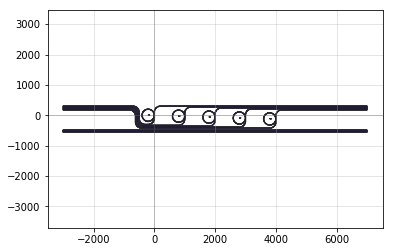

In [201]:
D = Device('CJC')

def z_shape(width=1.5, radius=50, mid=50, left=100, right=100, layer=0):
    D = Device('z_shape')
    LW = D << mn.waveguide(width=width,length=left,layer=layer)
    BD1 = D << pg.turn(port=LW.ports[2],angle=90,radius=radius,angle_resolution=0.5)
    MD = D << mn.extend(port=BD1.ports[2],length=mid)
    BD2 = D << pg.turn(port=MD.ports[2],angle=-90,radius=radius,angle_resolution=0.5)
    RW = D << mn.extend(port=BD2.ports[2],length=right)
    return D

PD = 1e3
num = 5

w = 2.0
width_bus = w
width_rg = w

ext = 2.5e3
rad = 200
SD = 30

LB_CEL = Device('LB_CEL')
for i in range(num):
    gap = 0.10 + i*0.03
    RG_CEL = Device('RG_CEL')
    RG = RG_CEL << pg.ring(radius=rad,width=width_rg)
    BUS =RG_CEL << mn.waveguide(length=rad,width=width_bus).movex(-.5*rad)
    RG.ymin = BUS.ymax + gap
    RG_CEL.rotate(90).move((PD*i,-SD*i))
    LB_CEL << pg.text(text='GAP%d' % (1e3*gap),position=(-rad+PD*i,-SD*i),layer=1)
    CN1 = pg.connector((7e3,BUS.ymax+rad),width=width_bus)
    RT1 = RG_CEL << pr.route_manhattan(port1=CN1.ports[2],port2=BUS.ports[2],bendType='circular',radius=rad)
    CN2 = pg.connector((-(i+10)*SD,BUS.ymin-rad),width=width_bus)
    RT2 = RG_CEL << pr.route_manhattan(port1=CN2.ports[1],port2=BUS.ports[1],bendType='circular',radius=rad)
    CN3 = pg.connector((-3e3,BUS.ymax+rad),width=width_bus)
    RT3 = RG_CEL << pr.route_manhattan(port1=CN3.ports[1],port2=CN2.ports[2],bendType='circular',radius=rad)
    D << RG_CEL

bar =  mn.waveguide(length=10e3,width=width_bus).move((-3e3,-550))
for i in range(3):
    D << pg.copy(bar).movey(i*SD)
    
D_out = pg.outline(D.flatten(),distance=8,layer=1)
D_out << LB_CEL
# D_out << pg.copy(D_out).movey(2e3)   
# D_out << pg.copy(D_out).movey(1e3)
D_out.flatten().write_gds('180416_ring_array_%d.gds' % (1e3*width_rg))

qp(D_out)

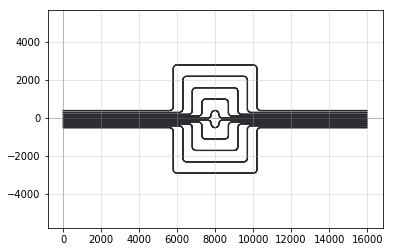

In [61]:
D = Device('array')

def swing(length=1.3e3, height=100, bend=200):
    D = Device('swing')
    subL = length - height - 2*bend
    assert subL > 100
    WG1 = D << mn.waveguide(length=subL,width=1.5)
    BD1 = D << pg.turn(port=WG1.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG2 = D << mn.extend(port=BD1.ports[2],length=height)
    BD2 = D << pg.turn(port=WG2.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG3 = D << mn.extend(port=BD2.ports[2],length=2*height)
    BD3 = D << pg.turn(port=WG3.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG4 = D << mn.extend(port=BD3.ports[2],length=height)
    BD4 = D << pg.turn(port=WG4.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG5 = D << mn.extend(port=BD4.ports[2],length=subL)
    return D
# arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)

for i in range(5):
    D << swing(length=8e3,height=i*500).movey(i*100)
#     D << swing(height=200).movey(50)
#     D << swing(height=300).movey(100)

D << pg.copy(D).rotate(180).move((16e3,-100))
D_out = pg.outline(D.flatten(), distance=8, layer=1) 
# D.flatten().write_gds('swing_array.gds')
qp(D_out)
D_out.write_gds('180409_swing_posi_1500.gds')

In [2]:
def asym(width = 10, height1 = 1, height2 = 0.8):
    WG = Device('asym')
    gap=(height1-height2)*0.5
    WG.add_polygon( [(0, -height1*0.5), (width, -height2*0.5), (width, height2*0.5), (0, height1*0.5)] )
#     WG.add_port(name = 'wgport1', midpoint = [0,height/2], width = height, orientation = 180)
#     WG.add_port(name = 'wgport2', midpoint = [width,height/2], width = height, orientation = 0)
    return WG

def taper_guide():
    D = Device('taper_guide')
    left= D << waveguide(3e3,0.7)
    right  =D << waveguide(3e3,0.7).movex(7e3)
    center= D << waveguide(3e3,0.4).movex(3.5e3).movey(0.15)
    D << asym(width=0.5e3,height1=0.7,height2=0.4).movex(3e3).movey(0.35)
    D << asym(width=0.5e3,height1=0.4,height2=0.7).movex(6.5e3).movey(0.35)
    return D

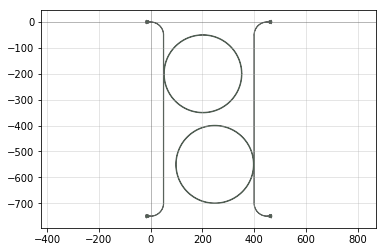

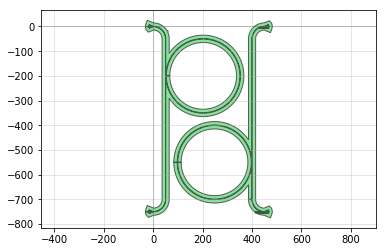

In [2]:
D = Device('PG')

args = {'width': 1}
pitch = 250*3

WG = Device('WG')
bt1 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(90).move((0,-50))
WG << mn.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args)

bt2 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(180).move((0,50-pitch))
WG << mn.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args).movey(-pitch)

bus = WG << pr.route_basic(port1=bt2.ports[1],port2=bt1.ports[2])

WG1 = D << pg.copy(WG).reflect([0,0], [0,1])
WG2 = D << pg.copy(WG).movex(450)

rg = pg.ring(150, 2).movey(-200)

RG1 = D << pg.copy(rg)
RG1.xmin = WG1.xmax + 0.4

RG2 = D << pg.copy(rg).movey(-350)
RG2.xmax = WG2.xmin - 0.5


D_out = pg.outline(D, distance = 14)


qp(D)
qp(D_out)
# D_out.write_gds('arc_gc.gds')
# D.xmax-D.xmin
# D.write_gds('arc_graitng.gds')

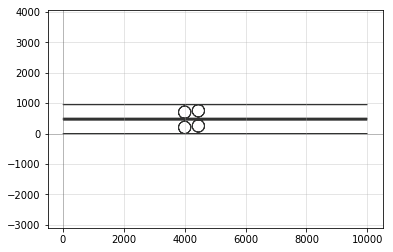

In [34]:
wgL = 10e3 # mm
wgW = 1
rgW = 1.5
rgR = 200

D = Device()

gap = np.arange(6)*0.05+0.2

WG1 = D << mn.waveguide(length=wgL, width=wgW)
WG2 = D << mn.waveguide(length=wgL, width=wgW).movey(450)
WG3 = D << mn.waveguide(length=wgL, width=wgW).movey(500)
WG4 = D << mn.waveguide(length=wgL, width=wgW).movey(950)

RG = pg.ring(rgR, rgW)
RG.ymin = WG1.ymax + gap[0]
RG.movex(4e3)
D << RG

RG = pg.ring(rgR, rgW).movex(450)
RG.ymax = WG2.ymin - gap[1]
RG.movex(4e3)
D << RG

RG = pg.ring(rgR, rgW)
RG.ymin = WG3.ymax + gap[2]
RG.movex(4e3)
D << RG

RG = pg.ring(rgR, rgW).movex(450)
RG.ymax = WG4.ymin - gap[3]
RG.movex(4e3)
D << RG

D.flatten()
qp(D)

D_out = pg.outline(D, distance = 14)
D.write_gds('view.gds')
D_out.write_gds('view_out.gds')


In [35]:
RG

Device (name "ring" (uid 234),  ports [], aliases [], 1 elements, 0 references)

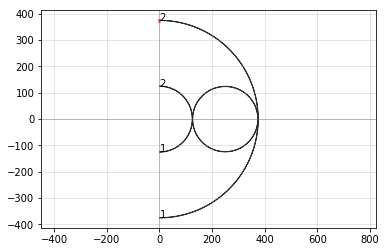

In [5]:
D = Device('AD-MRR')

w = 1
pitch = 250
gap = 0

ra1 = pitch/2
ra2 = 3*pitch/2
r = (ra2 - ra1)/2 - gap - w

args = {'width': w,
        'layer': 0}
arc1 = D << pg.arc(radius=ra1,start_angle=-90,theta=180,**args)
arc2 = D << pg.arc(radius=ra2,start_angle=-90,theta=180,**args)
rg = D << mn.ring(radius=r,**args,angle_resolution=1).move((r+ra1+gap+w,0))

# bus = D << mn.waveguide(length=100,**args)

# D << pg.deepcopy(bus) 
qp(D)

D.write_gds('templates/AD-MRR.gds')

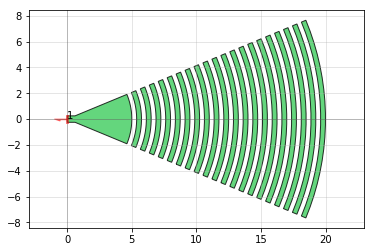

In [3]:
D = Device('PG')

D << pg.arc(radius=10,start_angle=0,theta=90,width=2)
D << mn.arc_grating()
qp(D)
D.write_gds('arc_gc.gds')
# D.write_gds('arc_graitng.gds')

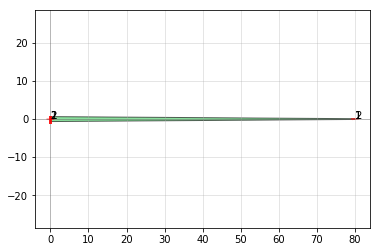

In [23]:
D = Device('mode_converter')

length = 80
CT1 = D << pg.connector(width=0.2).movex(length)
CT2 = D << pg.connector(width=1.3)
TP = D << pr.route_basic(port1=CT1.ports[1],port2=CT2.ports[2])

qp(D)
# D.write_gds('inverse_taper.gds')

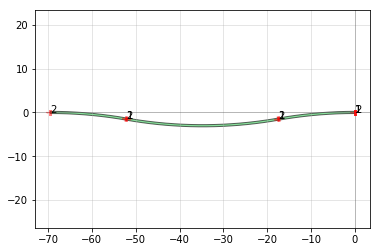

In [47]:
D = Device('bus')

wg1 = D << pg.connector(width=0.5)
arc1 = D << pg.turn(wg1.ports[2],angle=10,radius=100,angle_resolution=1)
arc2 = D << pg.turn(arc1.ports[2],angle=-20,radius=100,angle_resolution=1)
arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)
# wg2 = D << waveguide(0.5,20)
qp(D)
# D.write_gds('view.gds')

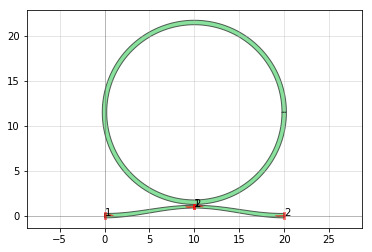

'view.gds'

In [34]:
D = Device('bus')

# gt1 = D << mn.arc_grating().rotate(180)
a1 = pg.connector((0,0),0.5)
a2 = pg.connector((10,1),0.3)
a3 = pg.connector((20,0),0.5)

w1 = D << pr.route_basic(port1=a1.ports[2],port2=a2.ports[1])
w2 = D << pr.route_basic(port1=a2.ports[2],port2=a3.ports[1])
rg = D << pg.ring(radius=10, width=0.5).move((10,12))

rg.ymin = w1.ymax + 0.1
qp(D)
D.write_gds('view.gds')

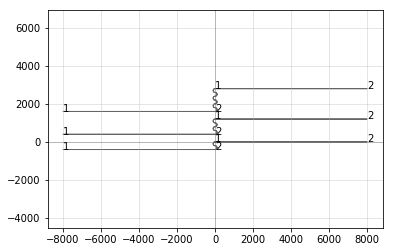

'simple_s.gds'

In [2]:
D = Device('simple')

l = 8e3
bend = 100
w = 1
wg1 = D << mn.waveguide(w,l)
wg2 = D << mn.waveguide(w,l).move((-l,-4*bend))

S = Device('s_shape') 
wg0 = S << pg.connector(width=w)
arc1 = S << pg.turn(wg0.ports[2],angle=180,radius=bend,angle_resolution=1)
arc2 = S << pg.turn(arc1.ports[2],angle=-180,radius=bend,angle_resolution=1)
D << S

y_shift = 6*2*bend
wg1 = D << mn.waveguide(w,l).move((0,y_shift))
wg2 = D << mn.waveguide(w,l).move((-l,y_shift-8*bend))

S1 = pg.copy(S)
D << S1.movey(y_shift)
S2 = pg.copy(S)
D << S2.movey(y_shift-4*bend)


y_shift = 14*2*bend
wg1 = D << mn.waveguide(w,l).move((0,y_shift))
wg2 = D << mn.waveguide(w,l).move((-l,y_shift-12*bend))

S1 = pg.copy(S)
D << S1.movey(y_shift)
S2 = pg.copy(S)
D << S2.movey(y_shift-4*bend)
S2 = pg.copy(S)
D << S2.movey(y_shift-8*bend)

# y_shift = 16*2*bend
# wg1 = D << mn.waveguide(w,l).move((0,y_shift))
# wg2 = D << mn.waveguide(w,l).move((-l,y_shift-16*bend))

# S1 = pg.copy(S)
# D << S1.movey(y_shift)
# S2 = pg.copy(S)
# D << S2.movey(y_shift-4*bend)
# S3 = pg.copy(S)
# D << S2.movey(y_shift-8*bend)
# S4 = pg.copy(S)
# D << S2.movey(y_shift-12*bend)

qp(D)
D.write_gds('simple_s.gds')


In [6]:
def s_shape(l):
    D = Device()
    wg = D << mn.waveguide(width=w,length=l).movex(-l/2).rotate(90)
    b1 = D << pg.turn(wg.ports[1],angle=-90,radius=bend,angle_resolution=2)
    b2 = D << pg.turn(wg.ports[2],angle=-90,radius=bend,angle_resolution=2)
#     D << mn.waveguide()
    return D

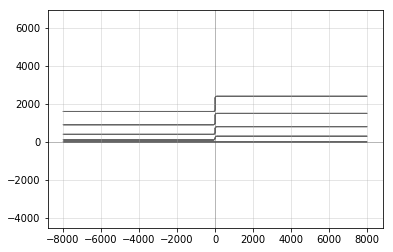

'simple.gds'

In [7]:
D = Device('simple')

l = 8e3
wg0 = D << mn.waveguide(w,2*l).movex(-l)

bend = 100
w = 1

step = 200
ys = 0
for i in range(4):
    ys += (i+1)*step
    S = Device('S_shape')
    h=i*step
    S << pg.copy(s_shape(h))
    S << mn.waveguide(w,l-bend).move((bend,h/2+bend))
    S << mn.waveguide(w,l-bend).move((-l,-h/2-bend))
    D << S.movey(ys)

D.flatten()
qp(D)
D.write_gds('simple.gds')


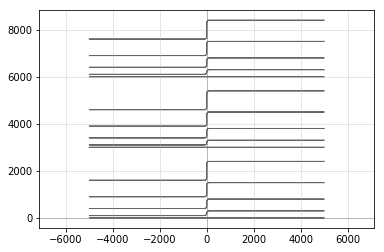

'simple_set.gds'

In [12]:
D = Device('simple')

l = 5e3

bend = 100
w = 1

wg0 = D << mn.waveguide(w,2*l).movex(-l)


step = 200
ys = 0
for i in range(4):
    ys += (i+1)*step
    S = Device('S_shape')
    h=i*step
    S << pg.copy(s_shape(h))
    S << mn.waveguide(w,l-bend).move((bend,h/2+bend))
    S << mn.waveguide(w,l-bend).move((-l,-h/2-bend))
    D << S.movey(ys)

D.flatten()

D_set = Device('final')

D_set << pg.deepcopy(D)
D_set << pg.deepcopy(D).movey(3e3)
D_set << pg.deepcopy(D).movey(6e3)

qp(D_set)
D_set.write_gds('simple_set.gds')
